In [1]:
## Imports

In [2]:
# TDastro libraries
import lsdb  # To get Rubin data

from tdastro.astro_utils.mag_flux import flux2mag, mag2flux  # AB mags <-> nJy
from tdastro.astro_utils.passbands import PassbandGroup  # Filter transmissions
from tdastro.base_models import FunctionNode  # Define custom parameter samplers
from tdastro.math_nodes.np_random import NumpyRandomFunc  # Parameter sampling with numpy.random
from tdastro.math_nodes.ra_dec_sampler import OpSimUniformRADECSampler  # Sky position sampling
from tdastro.opsim.opsim import OpSim  # Deal with LSST cadence and noise simulations
from tdastro.simulate import simulate_lightcurves
from tdastro.sources.lightcurve_source import LightcurveSource  # Source model
from tdastro.sources.physical_model import BandfluxModel  # Source model built from function

In [3]:
# VBMicrolensing
import VBMicrolensing

In [4]:
# Other packages
import matplotlib.pyplot as plt  # For plots
import numpy as np  # For math
import pandas as pd  # For tabular data

from astropy import units as u
from astropy.coordinates import SkyCoord

%matplotlib widget

## Grabbing OpSims

In [5]:
opsim_url = "https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs4.3/baseline//baseline_v4.3.3_10yrs.db"
opsim_data = OpSim.from_url(opsim_url)

2025-08-11 18:15:30,498 - INFO - Data file /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/opsim/baseline_v4.3.3_10yrs.db already exists. Skipping download.


In [6]:
# Time offset
lightcurve_t0 = 61100.0 # has to be in MJD (OpSim is in MJD)

# LSST Pabssands
lsst_passbands = PassbandGroup.from_preset("LSST")

2025-08-11 18:16:13,384 - INFO - Loading passbands from preset LSST
2025-08-11 18:16:13,387 - INFO - Data file /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/passbands/LSST/u.dat already exists. Skipping download.
2025-08-11 18:16:13,389 - INFO - Loading passband from file: /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/passbands/LSST/u.dat
2025-08-11 18:16:13,404 - INFO - Data file /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/passbands/LSST/g.dat already exists. Skipping download.
2025-08-11 18:16:13,404 - INFO - Loading passband from file: /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/passbands/LSST/g.dat
2025-08-11 18:16:13,410 - INFO - Data file /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/passbands/LSST/r.dat already exists. Skipping download.
2025-08-11 18:16:13,411 - INFO 

## Simulating a microlensing event with TDAstro and VBMicrolensing

In [7]:
# Setting up a MicrolensingSource class
class MicrolensingSource(BandfluxModel):
    '''
    This model is pure PSPL without blend and parallax.
    They can be added later.
    '''
    def __init__(
        self,
        # lightcurve_grid,
        t_0,
        u_0,
        t_E,
        source_fluxes,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.add_parameter("t_0", value=t_0)
        self.add_parameter("u_0", value=u_0)
        self.add_parameter("t_E", value=t_E)
        for flt, source_flux in source_fluxes.items():
            self.add_parameter(f"source_flux_{flt}", value=source_flux)        
    
    def compute_bandflux(self, times, filters, state, rng_info=None):
        params = self.get_local_params(state)

        VBM = VBMicrolensing.VBMicrolensing()

        # Array of parameters
        # Note that we give some parameters in log scale
        pr = [np.log(params["u_0"]), 
              np.log(params["t_E"]),
              params["t_0"]]
        
        # Calculates the PSPL magnification at different times with parameters in pr
        # Attention: VBMicrolensing assumes that times is an np.array or a list.
        results = VBM.PSPLLightCurve(pr, times)  
        
        # array of magnifications at each time in time_stamp
        magnifications = np.asarray(results[0])
        
        unique_filters = np.unique(filters)

        # I think I will have to initialize bandflux in a smart way,
        # but I don't know how. It's unclear from the example what
        # sort of an array simulate_lightcurves needs as an output here.
        # print("In class, unique filters:", unique_filters)
        # print("In class, filters", filters)
        
        bandflux = np.zeros_like(times)
        for flt in unique_filters:
            idx_mask = filters == flt
            amplified_flux = magnifications[idx_mask] * params.get(f"source_flux_{flt}", 0.0)
            bandflux[idx_mask] = amplified_flux
                    
        return bandflux 

In [10]:
# Long-duration microlensing event
event_parameters = {'t_0': 62100.0, 
                    'u_0': 0.1, 
                    't_E': 70.0, 
                   }

event_mag = {'u': 23., 'g': 22., 'r': 21.5, 'i': 21., 'z': 20.5, 'y': 19.5}

event_fluxes = {
    'u': mag2flux(event_mag['u']),
    'g': mag2flux(event_mag['g']),
    'r': mag2flux(event_mag['r']),
    'i': mag2flux(event_mag['i']),
    'z': mag2flux(event_mag['z']),
    'y': mag2flux(event_mag['y']),
}
                              
# I will simulate an ideal light curve for this event
time_stamps = np.arange(0, 10000., 0.1)
# Adding a constant shift to simulate parallax properly
time_stamps += 60500.0

# Hard-coded coordinates of the event
Ra, Dec = 265.72475, -33.75417 #HCZ

In [11]:
selected_lsst_passbands = PassbandGroup.from_preset("LSST", 
                                                    filters=['u', 'g', 'r', 'i', 'z', 'y']
                                                   )

microlensing_source = MicrolensingSource(
    event_parameters['t_0'],
    event_parameters['u_0'],
    event_parameters['t_E'],
    event_fluxes,
    ra=Ra,
    dec=Dec
)

sims = simulate_lightcurves(
    microlensing_source,
    1,
    opsim_data,
    selected_lsst_passbands,
    param_cols=['MicrolensingSource_0.t_0',
                'MicrolensingSource_0.u_0',
                'MicrolensingSource_0.t_E',
                'MicrolensingSource_0.source_flux_g'
               ]
)

2025-08-11 18:20:58,384 - INFO - Loading passbands from preset LSST
2025-08-11 18:20:58,386 - INFO - Data file /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/passbands/LSST/u.dat already exists. Skipping download.
2025-08-11 18:20:58,387 - INFO - Loading passband from file: /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/passbands/LSST/u.dat
2025-08-11 18:20:58,399 - INFO - Data file /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/passbands/LSST/g.dat already exists. Skipping download.
2025-08-11 18:20:58,399 - INFO - Loading passband from file: /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/passbands/LSST/g.dat
2025-08-11 18:20:58,405 - INFO - Data file /home/katarzyna/Documents/Training/LINCC_Frameworks_Hackathon/.venv/lib/python3.12/data/passbands/LSST/r.dat already exists. Skipping download.
2025-08-11 18:20:58,405 - INFO 

In [13]:
simulated_lightcurve = sims["lightcurve"].iloc[0]
simulated_lightcurve

,mjd,filter,flux,fluxerr,flux_perfect
0,61150.423847,i,14591.598429,289.090109,14455.233127
1,61151.420755,z,23084.016327,542.415426,22910.006093
...,...,...,...,...,...
769,64594.990860,i,14499.980646,685.261269,14454.415563
770,64595.001699,z,23766.199670,1219.014014,22908.704826


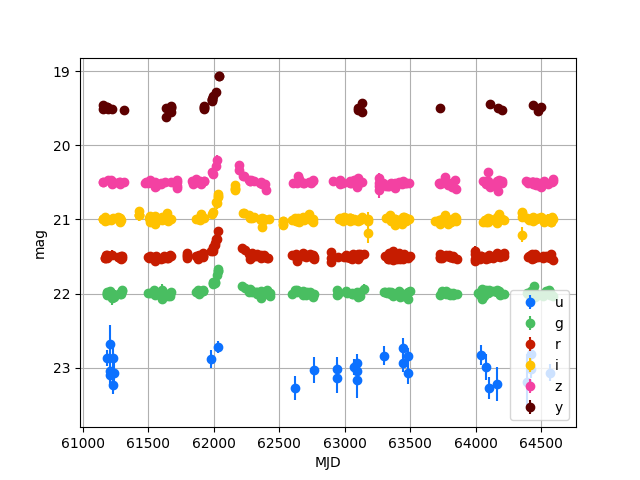

In [17]:
def flux_to_mag_df(df):
    df = df.copy()
    df = df.query("flux > 0")
    df["mag"] = flux2mag(df["flux"])
    df["magerr"] = 2.5 / np.log(10) * df["fluxerr"] / df["flux"]
    df["band"] = df["filter"]
    return df

COLORS = {
    "u": "#0c71ff",
    "g": "#49be61",
    "r": "#c61c00",
    "i": "#ffc200",
    "z": "#f341a2",
    "y": "#5d0000",
    "zg": "#62D03E",
    "zr": "#CC3344",
}


def plot_lc(df, period=None):
    df = df.copy()
    if period is not None and "phase" not in df.columns:
        mjd_min_light = df["mjd"][df.query("band == 'r'")["mag"].idxmax()]
        df["phase"] = (df["mjd"] - mjd_min_light) % period / period
    if period is None:
        x_col = "mjd"
    else:
        x_col = "phase"
    plt.figure()
    if len({"zg", "zr"} & set(df["band"])) > 0:
        for band in ["zg", "zr"]:
            data = df.query("band == @band")
            plt.errorbar(
                data[x_col],
                data["mag"],
                yerr=data["magerr"],
                label=f"{band}",
                fmt="o",
                color=COLORS[band],
                alpha=0.2,
            )
    for band in "ugrizy":
        data = df.query("band == @band")
        plt.errorbar(
            data[x_col], data["mag"], yerr=data["magerr"], label=f"{band}", fmt="o", color=COLORS[band]
        )

    plt.gca().invert_yaxis()
    if period is None:
        plt.xlabel("MJD")
    else:
        plt.xlabel("phase")
        plt.xlim([0, 1])
        plt.title(f"{period = } d")
    plt.ylabel("mag")
    plt.legend(loc="lower right")
    plt.grid(True)
    
mag_sim_lightcurve = flux_to_mag_df(simulated_lightcurve)
plot_lc(mag_sim_lightcurve, period=None)